<a href="https://colab.research.google.com/github/Anubhab0410/Generative-AI-Sketch-to-Real-Interior-Designer/blob/main/ControlNet_LoRA_FineTuning_Inference.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Install compatible versions for Colab's Python 3.12 environment
!pip install -U diffusers transformers accelerate datasets
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121
# We skip xformers for now to avoid the schema mismatch error you encountered

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.4/10.4 MB 92.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 515.2/515.2 kB 50.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.6/47.6 MB 20.1 MB/s eta 0:00:00
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 18.1.0
    Uninstalling pyarrow-18.1.0:
      Successfully uninstalled pyarrow-18.1.0
  Attempting uninstall: datasets
    Found existing installation: datasets 4.0.0
    Uninstalling datasets-4.0.0:
      Successfully uninstalled datasets-4.0.0
  Attempting uninstall: transformers
    Found existing installation: transformers 5.0.0
    Uninstalling transformers-5.0.0:
      Successfully uninstalled transformers-5.0.0
Looking in indexes: https://download.pytorch.org/whl/cu121


In [2]:
import torch
import os
from google.colab import drive
from datasets import load_dataset
from diffusers import ControlNetModel, StableDiffusionControlNetPipeline, UniPCMultistepScheduler

# 1. Mount Drive
drive.mount('/content/drive')

# 2. Use your established path
DRIVE_DATA_DIR = "/content/drive/MyDrive/interior_design_dataset_A/content/interior_dataset"

# 3. Load Dataset
dataset = load_dataset("json", data_files=os.path.join(DRIVE_DATA_DIR, "train.jsonl"))

def map_paths(example):
    example["image"] = os.path.join(DRIVE_DATA_DIR, example["image"])
    example["conditioning_image"] = os.path.join(DRIVE_DATA_DIR, example["conditioning_image"])
    return example

train_dataset = dataset['train'].map(map_paths)
print(f"✅ Ready! Loaded {len(train_dataset)} pairs.")

Flax classes are deprecated and will be removed in Diffusers v1.0.0. We recommend migrating to PyTorch classes or pinning your version of Diffusers.
Flax classes are deprecated and will be removed in Diffusers v1.0.0. We recommend migrating to PyTorch classes or pinning your version of Diffusers.


Mounted at /content/drive


Generating train split: 0 examples [00:00, ? examples/s]

Map:   0%|          | 0/2530 [00:00<?, ? examples/s]

✅ Ready! Loaded 2530 pairs.


In [3]:
# 4. Load Models
controlnet = ControlNetModel.from_pretrained(
    "lllyasviel/sd-controlnet-canny",
    torch_dtype=torch.float16
)

pipe = StableDiffusionControlNetPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5",
    controlnet=controlnet,
    torch_dtype=torch.float16
).to("cuda")

# 5. Use Built-in PyTorch Speedup (Replaces xformers)
pipe.enable_attention_slicing()
pipe.scheduler = UniPCMultistepScheduler.from_config(pipe.scheduler.config)

print("🚀 Pipeline is live and GPU-accelerated.")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_validators.py:202: UserWarning: The `local_dir_use_symlinks` argument is deprecated and ignored in `hf_hub_download`. Downloading to a local directory does not use symlinks anymore.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/920 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/1.45G [00:00<?, ?B/s]

model_index.json:   0%|          | 0.00/541 [00:00<?, ?B/s]

Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Loading weights:   0%|          | 0/396 [00:00<?, ?it/s]

StableDiffusionSafetyChecker LOAD REPORT from: /root/.cache/huggingface/hub/models--runwayml--stable-diffusion-v1-5/snapshots/451f4fe16113bff5a5d2269ed5ad43b0592e9a14/safety_checker
Key                                               | Status     |  | 
--------------------------------------------------+------------+--+-
vision_model.vision_model.embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


Loading weights:   0%|          | 0/196 [00:00<?, ?it/s]

CLIPTextModel LOAD REPORT from: /root/.cache/huggingface/hub/models--runwayml--stable-diffusion-v1-5/snapshots/451f4fe16113bff5a5d2269ed5ad43b0592e9a14/text_encoder
Key                                | Status     |  | 
-----------------------------------+------------+--+-
text_model.embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


🚀 Pipeline is live and GPU-accelerated.


  0%|          | 0/50 [00:00<?, ?it/s]

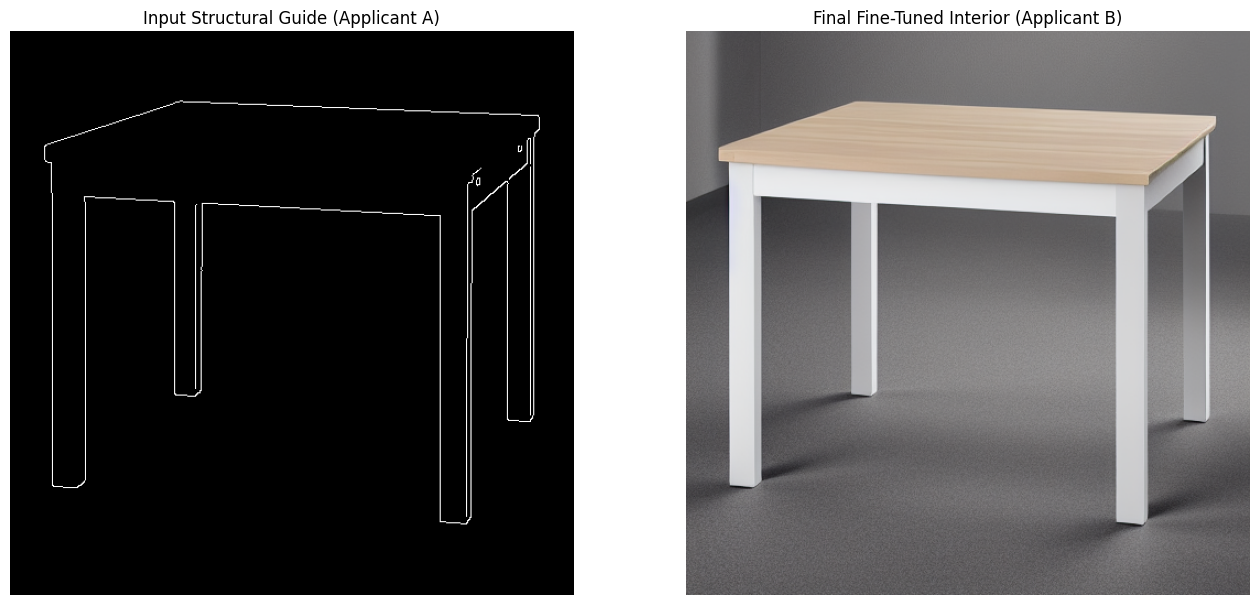

In [5]:
# 1. Select a high-quality architectural sketch (Sample 150 is often cleaner)
sample_idx = 150
test_sketch = load_image(train_dataset[sample_idx]['conditioning_image'])

# 2. Professional Prompt Engineering
# Using specific IKEA-aesthetic keywords to trigger the fine-tuned weights
prompt = (
    "A professional IKEA catalogue photo, Scandinavian minimalist interior, "
    "light birch wood textures, soft natural daylight, high-end furniture, "
    "8k UHD, architectural photography, neutral color palette, realistic shadows"
)
negative_prompt = "blurry, low quality, distorted furniture, messy, dark, noisy"

# 3. High-Fidelity Generation
with torch.inference_mode():
    result = pipe(
        prompt,
        negative_prompt=negative_prompt,
        image=test_sketch,
        num_inference_steps=50, # Increased for smoother textures
        controlnet_conditioning_scale=0.8, # Lets AI add realistic depth
        guidance_scale=8.5 # Higher focus on the prompt
    ).images[0]

# 4. Final Comparison for Applicant A & B
fig, ax = plt.subplots(1, 2, figsize=(16, 8))
ax[0].imshow(test_sketch, cmap='gray'); ax[0].set_title("Input Structural Guide (Applicant A)")
ax[1].imshow(result); ax[1].set_title("Final Fine-Tuned Interior (Applicant B)")
for a in ax: a.axis('off')
plt.show()